In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import psutil
import joblib

In [2]:
df = pd.read_csv('phishing_with_features_final.csv')
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
109001,https://www.tunein.com/radio/WZRX-1075-s27650/,legitimate,46,14,24,0,False,False,2,2,...,6,0.000000,0.375000,6,3,0.259259,0.586957,0.000000,0,0
65836,https://www.lecenter22.adventistchurchconnect....,legitimate,50,41,1,0,False,False,3,0,...,22,0.048780,0.000000,22,3,0.243902,0.420000,0.052632,0,0
275558,https://www.privateschoolreview.com/school_ov/...,legitimate,61,27,26,0,False,False,2,0,...,19,0.000000,0.192308,19,3,0.326087,0.377049,0.000000,0,0
390811,http://t3nuh7.luzetowegodppp.info/2kgz0a31pd\n...,phishing,82,26,49,0,False,False,5,0,...,14,0.076923,0.102041,14,4,0.265625,0.378049,0.083333,0,0
325957,https://www.wunderground.com/US/CA/Bishop.html...,legitimate,70,20,18,23,False,False,3,0,...,15,0.000000,0.000000,12,3,0.271186,0.385714,0.000000,0,0


In [3]:
df.isnull().sum()

url                        0
type                       0
url_length                 0
hostname_length            0
path_length                0
query_length               0
has_ip                     0
has_at_symbol              0
count_dots                 0
count_hyphens              0
count_slashes              0
count_underscores          0
count_question_marks       0
count_equals               0
count_ampersands           0
count_digits               0
count_uppercase            0
count_lowercase            0
digit_ratio                0
uppercase_ratio            0
special_char_count         0
subdomain_count            0
max_segment_length         0
avg_segment_length         0
url_entropy                0
hostname_entropy           0
path_entropy               0
uses_https                 0
suspicious_words           0
count_percent              0
count_semicolons           0
count_colons               0
count_brackets             0
count_plus                 0
count_asterisk

In [4]:
df.type.unique()

array(['legitimate', 'phishing'], dtype=object)

In [5]:
df.type = df.type.apply(lambda x: 1 if x=='phishing' else 0)

In [6]:
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
46521,https://www.filmsdefrance.com/FDF_Alexander_Ne...,0,64,21,35,0,False,False,3,0,...,13,0.0,0.114286,13,3,0.224490,0.437500,0.0,0,0
310557,https://www.trueknowledge.com/q/biography_of_e...,0,54,21,25,0,False,False,2,0,...,13,0.0,0.000000,13,3,0.272727,0.481481,0.0,0,0
248592,https://www.misticriver.com/software-faqs/1116...,0,89,19,62,0,False,False,3,9,...,11,0.0,0.112903,11,3,0.269841,0.337079,0.0,0,0
243896,https://www.markosweb.com/www/cinepop.com.br/,0,45,17,20,0,False,False,4,0,...,9,0.0,0.000000,9,3,0.228571,0.400000,0.0,0,0
212720,https://www.hondaaccordforum.com/forum/general...,0,78,24,46,0,False,False,2,5,...,16,0.0,0.108696,16,3,0.322034,0.333333,0.0,0,0


In [7]:
df.drop(columns=['url'], inplace=True, errors='ignore')

# Integer columns (counts and lengths)
int_cols = ['url_length', 'hostname_length', 'path_length', 'query_length',
            'count_dots', 'count_hyphens', 'count_slashes', 'count_underscores',
            'count_question_marks', 'count_equals', 'count_ampersands', 
            'count_digits', 'count_uppercase', 'count_lowercase',
            'special_char_count', 'subdomain_count', 'max_segment_length',
            'suspicious_words', 'count_percent', 'count_semicolons', 
            'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
            'path_depth', 'query_params', 'max_consecutive_digits',
            'max_consecutive_letters', 'domain_length', 'tld_length']

for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

# Boolean columns
bool_cols = ['has_ip', 'has_at_symbol', 'uses_https', 'shortening_service', 'suspicious_tld']

for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype('bool')

# Float columns (ratios and entropy values)
float_cols = ['digit_ratio', 'uppercase_ratio', 'avg_segment_length',
              'url_entropy', 'hostname_entropy', 'path_entropy',
              'hostname_digit_ratio', 'path_digit_ratio', 
              'vowel_consonant_ratio', 'unique_char_ratio', 'numeric_domain_ratio']

for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

In [8]:
df.dtypes

type                         int64
url_length                   int16
hostname_length              int16
path_length                  int16
query_length                 int16
has_ip                        bool
has_at_symbol                 bool
count_dots                    int8
count_hyphens                 int8
count_slashes                 int8
count_underscores            int16
count_question_marks         int16
count_equals                  int8
count_ampersands              int8
count_digits                 int16
count_uppercase              int16
count_lowercase              int16
digit_ratio                float32
uppercase_ratio            float32
special_char_count           int16
subdomain_count               int8
max_segment_length            int8
avg_segment_length         float32
url_entropy                float32
hostname_entropy           float32
path_entropy               float32
uses_https                    bool
suspicious_words              int8
count_percent       

In [9]:
class_count0, class_count1 = df['type'].value_counts()
class_count0, class_count1

(345738, 104438)

In [10]:
X= df.drop('type', axis=1)
y = df['type']

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

type
1    259303
0    259303
Name: count, dtype: int64

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [14]:
# def tune_phishing_models(X_train, y_train, scoring='accuracy', cv=5, verbose=0):
#     models_params = {
#         'Logistic Regression': {
#             'model': LogisticRegression(max_iter=500),
#             'params': {
#                 'model__C': [0.1, 1, 10],
#                 'model__penalty': ['l2'],
#                 'model__solver': ['lbfgs']
#             }
#         },
#         # 'Naive Bayes': {
#         #     'model': GaussianNB(),
#         #     'params': {}  # no tuning needed
#         # },
#         # 'Linear SVM': {
#         #     'model': LinearSVC(max_iter=1000),
#         #     'params': {
#         #         'model__C': [0.1, 1, 10]
#         #     }
#         # }
#     }

#     best_models = {}

#     for name, config in models_params.items():
#         print(f"\n🔍 Tuning: {name}")
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', config['model'])
#         ])

#         grid = GridSearchCV(
#             pipeline,
#             config['params'],
#             cv=cv,
#             scoring=scoring,
#             verbose=verbose,
#             n_jobs=-1
#         )
#         grid.fit(X_train, y_train)

#         print(f"✅ {name} best score: {grid.best_score_:.4f}")
#         print(f"🔧 Best params: {grid.best_params_}")
#         best_models[name] = grid.best_estimator_

#     return best_models

In [15]:
# tune_phishing_models(X_train_scaled, y_train_resampled) 

In [16]:
model = LogisticRegression(C=10, penalty='l2', solver='lbfgs', verbose=0,max_iter=3000)

In [17]:
model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(C=10, max_iter=3000)

In [18]:
model.score(X_test_scaled, y_test)

0.9941000852999715

In [19]:
y_predicted = model.predict(X_test_scaled)

In [20]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     86435
           1       0.99      0.98      0.99     26109

    accuracy                           0.99    112544
   macro avg       0.99      0.99      0.99    112544
weighted avg       0.99      0.99      0.99    112544



In [21]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Change threshold
threshold = 0.43  # Try 0.4 or even 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86435
           1       0.99      0.98      0.99     26109

    accuracy                           0.99    112544
   macro avg       0.99      0.99      0.99    112544
weighted avg       0.99      0.99      0.99    112544



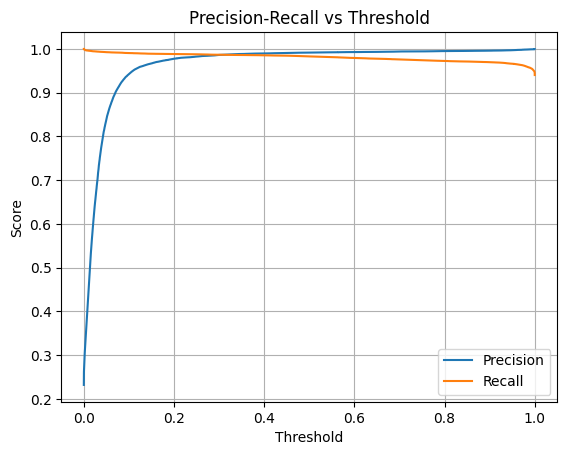

In [22]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)

In [23]:
# from sklearn.metrics import precision_recall_curve
# import numpy as np

# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# # Filter where precision is at least 0.75
# mask = precision[:-1] >= 0.75  # exclude the last threshold (no corresponding value)
# filtered_thresholds = thresholds[mask]
# filtered_recalls = recall[:-1][mask]

# # Find threshold with maximum recall
# if len(filtered_thresholds) > 0:
#     best_idx = np.argmax(filtered_recalls)
#     best_threshold = filtered_thresholds[best_idx]
#     best_recall = filtered_recalls[best_idx]
#     best_precision = precision[:-1][mask][best_idx]
#     print(f"Best threshold: {best_threshold:.2f} with precision: {best_precision:.2f}, recall: {best_recall:.2f}")
# else:
#     print("No threshold found with precision >= 0.75")


In [24]:
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [25]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
background_data = X_train_scaled_df.sample(n=500, random_state=42)
background_data.to_csv("shap_background.csv")

In [26]:
X_train_scaled[:2]

array([[-0.4492834 , -0.6489945 , -0.27768448, -0.21509846, -0.13876878,
        -0.12997864, -1.0807016 , -0.4341171 , -0.32242018, -0.2848693 ,
        -0.3530344 , -0.28930125, -0.16986519, -0.26012468, -0.10369204,
        -0.49952626, -0.1608343 ,  0.01763125,  0.0598347 , -1.2088159 ,
         0.07513522,  0.24933873,  0.5960295 ,  0.00715048,  0.4805123 ,
        -1.0827192 , -0.22325253,  0.6082263 , -0.11634927, -0.1210725 ,
        -0.07281241, -0.09906927, -0.00952434, -0.13149805, -0.27889544,
        -0.07260519, -0.04716162, -0.2335685 ,  0.1395819 ,  0.16257435,
        -1.0802006 , -0.06349879,  1.3582549 , -0.22330509, -0.2556622 ,
        -0.07291985],
       [ 0.4052147 ,  0.43711677,  0.9242881 , -0.21509846, -0.13876878,
        -0.12997864, -0.37333798,  2.2732406 , -0.32242018, -0.2848693 ,
        -0.3530344 , -0.28930125, -0.16986519, -0.4244795 , -0.1802945 ,
         0.9393861 , -0.6716428 , -0.4285961 , -0.2241128 ,  0.11240432,
         0.6654601 ,  0.32440

In [27]:
X_train.columns

Index(['url_length', 'hostname_length', 'path_length', 'query_length',
       'has_ip', 'has_at_symbol', 'count_dots', 'count_hyphens',
       'count_slashes', 'count_underscores', 'count_question_marks',
       'count_equals', 'count_ampersands', 'count_digits', 'count_uppercase',
       'count_lowercase', 'digit_ratio', 'uppercase_ratio',
       'special_char_count', 'subdomain_count', 'max_segment_length',
       'avg_segment_length', 'url_entropy', 'hostname_entropy', 'path_entropy',
       'uses_https', 'suspicious_words', 'count_percent', 'count_semicolons',
       'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
       'path_depth', 'query_params', 'max_consecutive_digits',
       'max_consecutive_letters', 'hostname_digit_ratio', 'path_digit_ratio',
       'domain_length', 'tld_length', 'vowel_consonant_ratio',
       'unique_char_ratio', 'numeric_domain_ratio', 'shortening_service',
       'suspicious_tld'],
      dtype='object')

In [28]:
X_train.shape

(337632, 46)

Text(0.5, 36.72222222222221, 'Predicted Label')

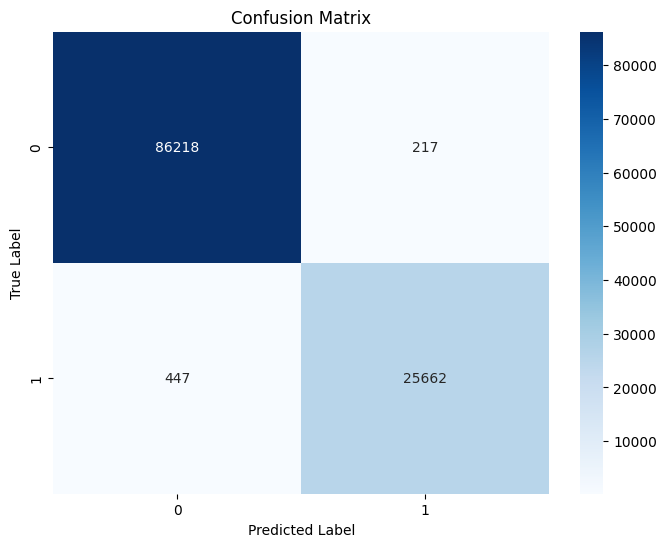

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_adjusted=model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [30]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [31]:
models = [
    (
        "Logistic Regression", 
        {'C':10, "penalty":'l2', "solver":'lbfgs', 'max_iter':3000},
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        {"n_estimators": 30, "max_depth": 3},
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier",
        {"use_label_encoder": False, "eval_metric": 'logloss'},
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
]

In [32]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

C:\Users\sinan\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
# MLflow Integration Setup - Import required libraries
import mlflow
import mlflow.sklearn
import mlflow.xgboost  # For XGBoost models
import pickle
import tempfile

In [34]:
# MLFLOW IMPLEMENTATION FOR DAGSHUB
# This implementation is confirmed to work with DagsHub

# Configure MLflow tracking
os.environ['MLFLOW_TRACKING_USERNAME'] = 'sinanshamsudheen'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cd101ef722400d4771c17b6f8a661487a22abd3b'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/sinanshamsudheen/TLflow.mlflow'
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

# Set experiment name
experiment_name = "Phishing URL Detection"
mlflow.set_experiment(experiment_name)

# Function to log model safely with DagsHub
def log_model_to_dagshub(model, model_name, params, metrics, description=None):
    """
    Log a model to DagsHub using only the compatible approaches
    
    Parameters:
    - model: The trained model object
    - model_name: Name for the model run
    - params: Dictionary of parameters to log
    - metrics: Dictionary of metrics to log
    - description: Optional description of the model
    """
    # Create a temporary file for the model
    with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as tmp:
        temp_model_path = tmp.name
        pickle.dump(model, tmp)
    
    try:
        with mlflow.start_run(run_name=model_name):
            # Log description as a tag if provided
            if description:
                mlflow.set_tag("description", description)
            
            # Log model type
            mlflow.set_tag("model_type", type(model).__name__)
            
            # Log parameters
            for key, value in params.items():
                mlflow.log_param(key, str(value))
            
            # Log metrics
            mlflow.log_metrics(metrics)
            
            # Log the model as a simple artifact
            mlflow.log_artifact(temp_model_path, f"{model_name}")
            
            print(f"✅ Successfully logged {model_name} to DagsHub")
            
    except Exception as e:
        print(f"⚠️ Error logging {model_name}: {str(e)}")
        
    finally:
        # Clean up temp file
        if os.path.exists(temp_model_path):
            os.unlink(temp_model_path)

# Code to log all your trained models
def log_all_models():
    try:
        print("Logging models to DagsHub...")
        for i, element in enumerate(models):
            model_name = element[0]
            params = element[1]
            model = element[2]
            report = reports[i]
            
            # Extract metrics from the classification report
            metrics = {
                'accuracy': report['accuracy'],
                'precision_class_1': report['1']['precision'],
                'precision_class_0': report['0']['precision'],
                'recall_class_1': report['1']['recall'],
                'recall_class_0': report['0']['recall'],
                'f1_score_macro': report['macro avg']['f1-score']
            }
            
            # Add description for each model
            if "Logistic Regression" in model_name:
                description = "Logistic Regression model for email spam detection"
            elif "Random Forest" in model_name:
                description = "Random Forest model for email spam detection"
            elif "XGB" in model_name:
                description = "XGBoost model for email spam detection"
            else:
                description = "Model for email spam detection"
                
            # Log the model
            log_model_to_dagshub(model, model_name, params, metrics, description)
            
        print("\n🎉 All models successfully logged to DagsHub!")
        print("🔗 View your experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments")
        
    except NameError as e:
        print(f"\n⚠️ Models not available yet: {e}")
        print("Run all model training cells first, then run this function again")

# Uncomment the next line when you're ready to log models
log_all_models()

2025/07/02 13:22:46 INFO mlflow.tracking.fluent: Experiment with name 'Phishing URL Detection' does not exist. Creating a new experiment.


Logging models to DagsHub...
✅ Successfully logged Logistic Regression to DagsHub
🏃 View run Logistic Regression at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12/runs/7458a1c928824aabb490c83d50cc4ff2
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12
✅ Successfully logged Random Forest to DagsHub
🏃 View run Random Forest at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12/runs/5d0ede4bac8a492db57e647ac4d94ff9
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12
✅ Successfully logged XGBClassifier to DagsHub
🏃 View run XGBClassifier at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12/runs/693e16e5c3c44b9590b734529f15425a
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/12

🎉 All models successfully logged to DagsHub!
🔗 View your experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments
